### Train & Save CombinedPipeline

Train the `Combined` **training set**, evaluate on **dev** and **test**, and save the fitted pipeline.

In [1]:
import os

import random
from pathlib import Path
import numpy as np

from utils import get_image_paths_and_labels, plot_cm_subset
from CombinedPipeline import CombinedPipeline

import warnings

warnings.filterwarnings(
    "ignore",
    message="SymbolDatabase.GetPrototype.*",
    module="google.protobuf.symbol_database"
)

TRAIN_DIR = '../data/asl_alphabet_train'
DEV_DIR = '../data/asl_alphabet_dev'
TEST_DIR = '../data/synthetic_test'

seed = 42
random.seed(seed)
np.random.seed(seed)

train_paths, train_labels = get_image_paths_and_labels(TRAIN_DIR)
dev_paths, dev_labels = get_image_paths_and_labels(DEV_DIR)
test_paths, test_labels = get_image_paths_and_labels(TEST_DIR)

classes = sorted(os.listdir(TRAIN_DIR))
subset_to_plot = [clazz for clazz in classes if clazz not in ['del', 'space']]

#### The pipeline

Display the underlying sklearn pipeline

In [2]:
pipe = CombinedPipeline()
pipe.plot_pipeline()

I0000 00:00:1746973751.386181 13386305 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('pca',
                                                 Pipeline(steps=[('loader',
                                                                  <ClassicalPipeline.ImageLoader object at 0x390a77510>),
                                                                 ('pca',
                                                                  PCA(n_components=20,
                                                                      random_state=42)),
                                                                 ('scaler_pix',
                                                                  StandardScaler())])),
                                                ('landmarks',
                                                 <HybridPipeline.MPFeatureExtractor object at 0x390a74dd0>)])),
                ('clf',
                 RandomForestClassifier(max_depth=20, max_features=0.3,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))])

#### Training

In [3]:
pipe.fit(train_paths, train_labels)
print("Trained CombinedPipeline on train")

Extracting hand landmarks: 100%|██████████| 75428/75428 [16:14<00:00, 77.38it/s]


Trained CombinedPipeline on train


#### Evaluate on dev

Extracting hand landmarks: 100%|██████████| 11600/11600 [02:31<00:00, 76.81it/s]


### DEV SET ###
Accuracy     : 0.9778
Macro-F1     : 0.9778


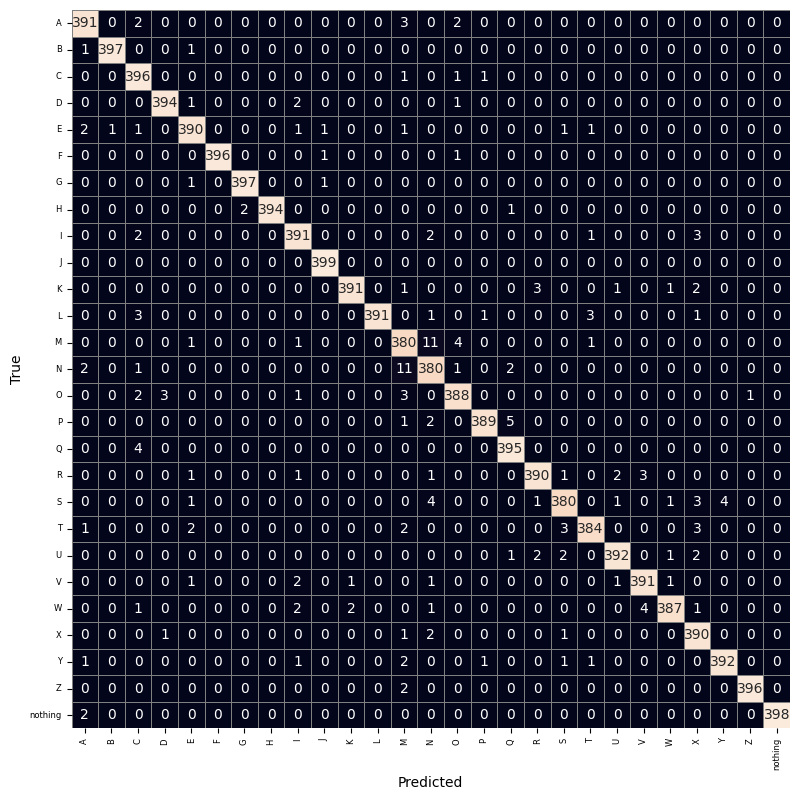

In [4]:
dev_metrics = pipe.evaluate(dev_paths, dev_labels)

print("### DEV SET ###")
print(f"Accuracy     : {dev_metrics['accuracy']:.4f}")
print(f"Macro-F1     : {dev_metrics['f1_macro']:.4f}")

plot_cm_subset(dev_metrics['cm'], classes, subset_to_plot)

#### Evaluate on test

Extracting hand landmarks: 100%|██████████| 2700/2700 [00:42<00:00, 63.59it/s]


### TEST SET ###
Accuracy     : 0.3570
Macro-F1     : 0.3425


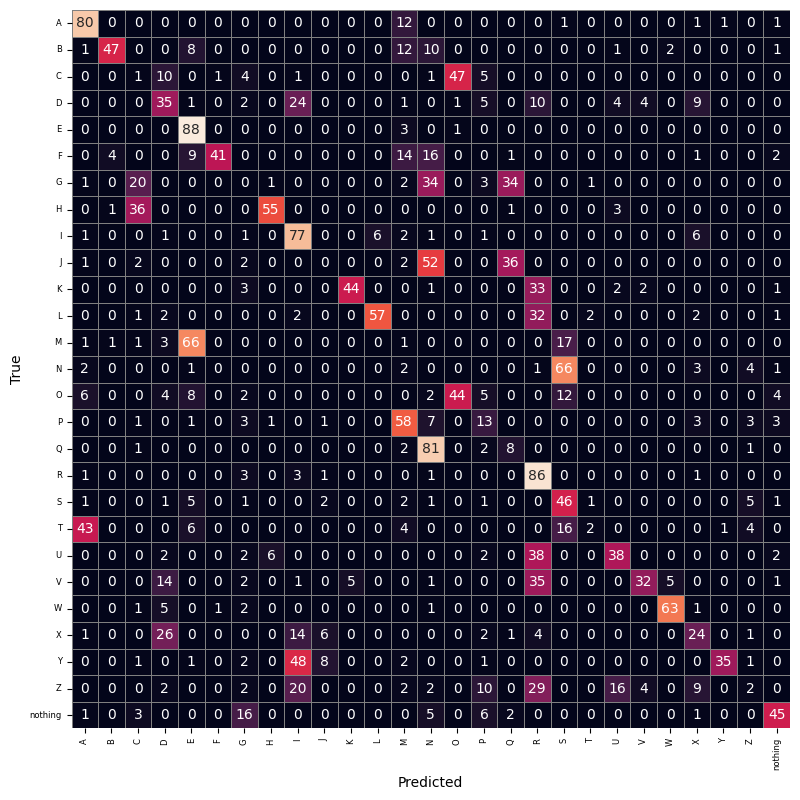

In [5]:
test_metrics = pipe.evaluate(test_paths, test_labels)

print("### TEST SET ###")
print(f"Accuracy     : {test_metrics['accuracy']:.4f}")
print(f"Macro-F1     : {test_metrics['f1_macro']:.4f}")

plot_cm_subset(test_metrics['cm'], classes, subset_to_plot)

#### Save model

In [6]:
out = Path('../models') / 'combined_pipeline.pkl'
out.parent.mkdir(exist_ok=True, parents=True)
pipe.save(str(out))
print(f"Saved CombinedPipeline to {out}")

Saved CombinedPipeline to ../models/combined_pipeline.pkl


#### Load Model and evaluate again

In [7]:
pipe2 = CombinedPipeline().load(str(out))
print(f"Loaded pipeline from {out}\n")

# 1) Eval on DEV
dev_metrics = pipe2.evaluate(dev_paths, dev_labels)
print("### DEV SET (reloaded) ###")
print(f"Accuracy     : {dev_metrics['accuracy']:.4f}")
print(f"Macro-F1     : {dev_metrics['f1_macro']:.4f}")

# 2) Eval on TEST
test_metrics = pipe2.evaluate(test_paths, test_labels)
print("### TEST SET (reloaded) ###")
print(f"Accuracy     : {test_metrics['accuracy']:.4f}")
print(f"Macro-F1     : {test_metrics['f1_macro']:.4f}")

Loaded pipeline from ../models/combined_pipeline.pkl



I0000 00:00:1746974987.265157 13386305 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4 Pro
I0000 00:00:1746974987.326672 13386305 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4 Pro
Extracting hand landmarks: 100%|██████████| 11600/11600 [02:31<00:00, 76.66it/s]


### DEV SET (reloaded) ###
Accuracy     : 0.9778
Macro-F1     : 0.9778


Extracting hand landmarks: 100%|██████████| 2700/2700 [00:43<00:00, 62.56it/s]

### TEST SET (reloaded) ###
Accuracy     : 0.3570
Macro-F1     : 0.3425
